<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/bsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the Black-Scholes-Merton Formula by FDM**

* **FDM** stands for **Finite Difference Method**.
* Thanks to
[Antoni Smolski](https://antonismolski.medium.com/?source=post_page-----965fd0539808--------------------------------)
for his inspiring BSM blog  
https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  
on which this notebook is based.

* The code in this notebook is largely Antoni's code with
  needed modifications to suite our course needs and targets.

* The Black-Scholes-Merton is the partial differential equation  
  $\quad
  v_t +rsv_s + \frac{1}{2}\sigma^2 s^2 v_{ss} = r v
  $

* $v(s,t)$ is the option value of a given asset at
   price $s$,  at time $t$.

* $r$ = risk-free interest rate

* $\sigma$ = the volatility of the stock (standard deviation)

* We use Python's [Numpy package](https://numpy.org), to model
  the **FDM** grid structure which represents the discrete
  version of $v(s,t)$.

* We use our **fdmtools** Python package,
  which is installed and imported by the next code cell.

In [1]:
%pip install -q https://samyzaf.com/fdmtools-3.zip
from fdmtools.bsm import *

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
#@title Black-Scholes-Merton Formula
#@markdown  Motivation Video
YouTubeVideo("A5w-dEgIU1M", width=640, height=360)

* The implementation is the straightforward modification of
  Antoni Smolski code.

* I highly recommend reading his Blog!  
  https://antonismolski.medium.com/implementation-of-black-scholes-formula-using-finite-difference-method-with-code-965fd0539808  

* Another useful source:  
https://diter.medium.com/option-pricing-using-the-black-scholes-model-without-the-formula-e09235f75fb7

In [9]:
# sigma = the volatility of the stock (standard deviation)
#       = the degree of variation of a trading price series over time
# r = risk-free interest rate
# K = Strike price
# Ns = Number of asset price steps
# Nt = Number of time steps (Nt=0 means choose optimal number)

def Solve(sigma, r, K, T, Ns, Nt=0):
    Price = np.zeros(Ns + 1)            # Ns = Number of Asset steps array
    S = 3*K                             # Max asset price
    ds = S/Ns                           # asset price step
    if Nt==0:                           # Automatic optimal selection of time step
        dt = 0.9 / (sigma**2 * Ns**2)   # Stable optimal value of dt
        Nt = int(T/dt) + 1              # Number of time steps
    dt = T / Nt                         # Ensure that T is an integer number of time steps away
    V = np.zeros((Ns+1, Nt+1))          # Option Value Array (V FDM grid)

    for i in range(Ns+1):
        Price[i] = i*ds
        V[i,0] = max(Price[i] - K, 0)   # Initial condition at time t=0

    for k in range(1, Nt+1):  # Time loop
        # And now ta dam ... Nobel prize winning diff equation ;)
        for i in range(1, Ns):  # Asset loop
            delta = (V[i+1,k-1] - V[i-1,k-1]) / (2*ds)                 # Vs[i,k] as central difference
            gamma = (V[i+1,k-1] - 2*V[i,k-1] + V[i-1,k-1]) / (ds**2)   # Vss[i,k] as central difference
            theta = -0.5 * sigma**2 * Price[i]**2 * gamma - r*Price[i]*delta + r*V[i,k-1]
            V[i, k] = V[i, k - 1] - dt * theta

        V[0,k] = 0                     # Boundary condition at s=0
        V[Ns,k] = S - K*exp(-r*k*dt)   # Boundary condition at s=S (Smax)

    asset_steps = np.arange(0, Ns + 1) * ds  # Asset price steps from 0 to S (i*ds, i=0,1,..,Ns)
    time_steps = np.arange(0, Nt + 1) * dt   # Time steps from 0 to T (k*dt, k=0,1,..,Nt)
    rounded_asset_steps = np.round(asset_steps, decimals=3)
    rounded_time_steps = np.round(time_steps, decimals=3)
    data = pd.DataFrame(np.transpose(V), index=rounded_time_steps, columns=rounded_asset_steps).round(3)
    data.attrs = dict(S=S, T=T, K=K, ds=ds, dt=dt, r=r, sigma=sigma)
    return data  # Output array as pandas data frame object



# Example
* In the following example we solve the BSM equation for a stock option
  with the following parameters.

In [10]:
K = 50            # Option strike price
S = 3*K           # Maximum asset price
T = 3             # Maximum time (in year units)
Ns = 40           # number of asset price steps
Nt = 0            # Let Solve choose an optimal number of time steps
sigma = 0.4       # Asset price sensitivity (aka volatility)
r = 0.05          # Interest rate

data = Solve(sigma, r, K, T, Ns, Nt)

* **data** is a [Pandas](https://pandas.pydata.org/)
  [DataFrame object](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
  which holds the FDM grid solution in a tabular form.
  This is a very useful info container which is easy to
  query.

* Here are the the first 5 rows of this table followed
  by the last 5 rows.
  
* The columns are asset price steps,
  and the lines are time steps.

In [11]:
data

,0.00,3.75,7.50,11.25,15.00,18.75,22.50,26.25,30.00,33.75,...,116.25,120.00,123.75,127.50,131.25,135.00,138.75,142.50,146.25,150.00
0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.250,70.000,73.750,77.500,81.250,85.000,88.750,92.500,96.250,100.000
0.004,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.259,70.009,73.759,77.509,81.259,85.009,88.759,92.509,96.259,100.009
0.007,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.268,70.018,73.768,77.518,81.268,85.018,88.768,92.518,96.268,100.018
0.011,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.276,70.026,73.776,77.526,81.276,85.026,88.776,92.526,96.276,100.026
0.014,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,66.285,70.035,73.785,77.535,81.285,85.035,88.785,92.535,96.285,100.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.986,0.0,0.001,0.025,0.147,0.465,1.050,1.933,3.119,4.592,6.333,...,74.485,78.063,81.651,85.247,88.850,92.459,96.072,99.690,103.311,106.934
2.989,0.0,0.001,0.025,0.147,0.467,1.053,1.937,3.124,4.599,6.340,...,74.495,78.072,81.660,85.256,88.858,92.467,96.081,99.698,103.319,106.942
2.993,0.0,0.001,0.025,0.148,0.468,1.055,1.941,3.129,4.605,6.347,...,74.504,78.082,81.669,85.265,88.867,92.475,96.089,99.706,103.326,106.949
2.996,0.0,0.001,0.025,0.149,0.470,1.058,1.945,3.134,4.611,6.355,...,74.513,78.091,81.678,85.273,88.876,92.484,96.097,99.714,103.334,106.957


* To see the table header (time steps) use the **index** method:

In [5]:
data.index

Index([  0.0, 0.004, 0.007, 0.011, 0.014, 0.018, 0.021, 0.025, 0.028, 0.032,
       ...
       2.968, 2.972, 2.975, 2.979, 2.982, 2.986, 2.989, 2.993, 2.996,   3.0],
      dtype='float64', length=855)

* Table columns (asset price steps):

In [ ]:
data.columns

* A Pandas DataFrame can be exporetd into a Microsoft Excel sheet easily!

In [6]:
data.to_excel("data.xlsx")

You can download this Excel sheet to your local disk by the following command.

In [7]:
file_download("data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# BSM Heatmap
* The method **bsm_heatmap** can be used for drawing
  a heatmap of the tabular **data**.

* This method is part of our
  [**fdmtools package**](https://samyzaf.com/fdmtools-3.zip)
  and can be viewed by downloading this package.

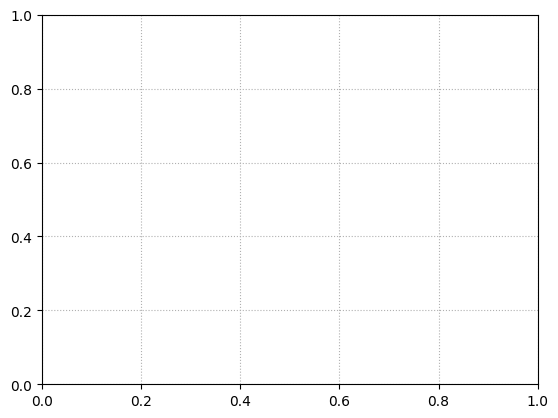

<Figure size 1000x600 with 0 Axes>

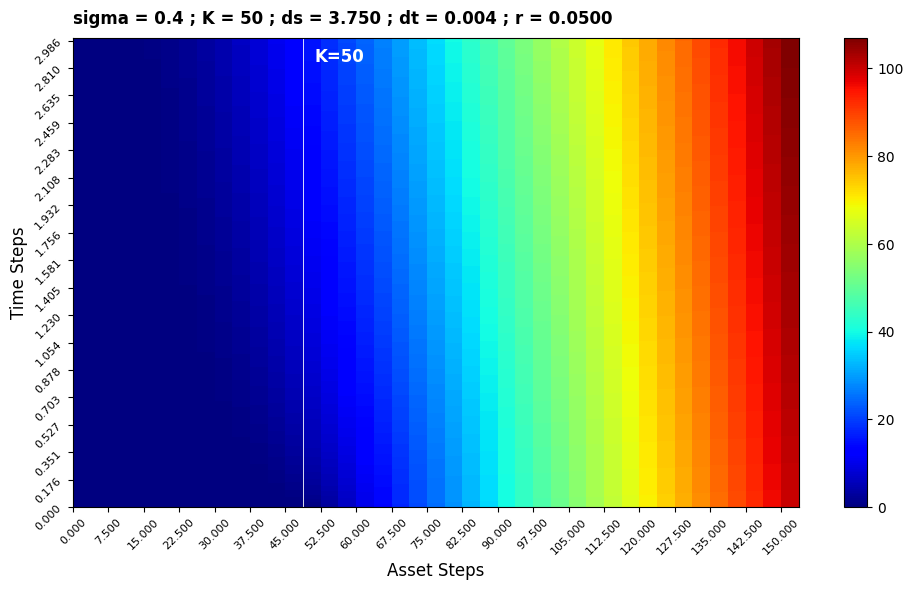

In [12]:
plt.figure(figsize=(10, 6))
bsm_heatmap(data)
plt.show()


In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

Y,X = np.meshgrid(data.columns, data.index)
Z = data.values
colormap = "jet"
surf = ax.plot_surface(X, Y, Z, cmap=colormap)

ax.set_xlabel('Time')
ax.set_ylabel('Asset Price')
ax.set_zlabel('Option Value')
ax.set_title('Option Value Surface Plot')
fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
plt.show()